# Importing necessary libraries & data, setting pandas' display options.

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from category_encoders import TargetEncoder
from category_encoders import OneHotEncoder
from category_encoders import OrdinalEncoder
from category_encoders import BinaryEncoder

from sklearn.metrics import precision_recall_curve, precision_score, recall_score,\
accuracy_score, f1_score, classification_report

import streamlit as st

In [2]:
c = pd.read_csv('courses.csv') #merged - cla
a = pd.read_csv('assessments.csv') #merged - stu_a
sa = pd.read_csv('studentAssessment.csv') #merged - stu_a
si = pd.read_csv('studentInfo.csv') #merged - s
sr = pd.read_csv('studentRegistration.csv') #merged - s
vle = pd.read_csv('vle.csv') #merged - cla
svle = pd.read_csv('studentVle.csv') #merged - cla

In [3]:
pd.set_option('display.max_columns', 500)

# Merging & cleaning data

In [4]:
# This field in the student information table has no value as an integar. Converting it to a string.
si['id_student'] = si.id_student.astype('str')

In [5]:
# Creating a unique identifier at the student course level. Will serve as the primary key.
#si['unique_stu_course'] = si.code_module+'_'+si.code_presentation+'_'+si.id_student

In [6]:
# Dropping redundant fields before merging.
vle.drop(labels=['code_module', 'code_presentation'], axis=1, inplace=True)

In [7]:
# Merging the two virtual learning environment tables, to create a new table "Learning Activity (la)".
la = pd.merge(svle, vle, how='left', on='id_site')

In [8]:
# Merging the courses table to create new table "Course Learning Activity (cla)".
cla = pd.merge(la, c, on=['code_module', 'code_presentation'], how='left')

In [9]:
# Dropping two fields that don't contain enough data and useful meaning.
cla.drop(labels=['week_from', 'week_to'], axis=1, inplace=True)

In [10]:
# This field in the student registration table has no value as an integar. Converting it to a string.
sr['id_student'] = sr.id_student.astype('str')

In [11]:
# Merging student information & registration into one table, "Students (s)"
s = pd.merge(si, sr, on=['code_module', 'code_presentation', 'id_student'])

In [12]:
# Merging student assessments with the assessments lookup table to retrieve assessment type & weight.
stu_a = pd.merge(sa, a, how='left', on='id_assessment')

In [13]:
# Filtering the course learning activity table to include the first 54 days of activity in course (20%)
c = cla[cla.date <= 54]

In [14]:
# Grouping the course learning activity table in order to aggregate clicks on activity type.
cg = c.groupby(['code_module', 'code_presentation', 'id_student', 'activity_type']).sum_click.sum().reset_index()

In [15]:
# Pivoting table to create features at the activity type level.
cp = pd.pivot_table(cg, values='sum_click', index=['code_module', 'code_presentation', 'id_student'],
               columns='activity_type', aggfunc='sum').reset_index()

In [16]:
# filling NaN with 0, as that is what NaN represents in this case.
cp = cp.fillna(0)

In [17]:
# Filtering the students table to exclude courses withdrawn before day 55 of course.
s = s[(s.date_unregistration > 54) | (s.date_unregistration.isna())]

In [18]:
cp['id_student'] = cp.id_student.astype('str')

In [19]:
# Merging for a final time to create the dataframe that will be used in my ML model.
df = pd.merge(s, cp, on=['code_module', 'code_presentation', 'id_student'])

# Featuring Engineering

In [20]:
# Dropping the withdrawal date field, as to avoid data leakage in my model.
df.drop(columns='date_unregistration', inplace=True)

In [21]:
df.rename(columns={'final_result': 'target'}, inplace=True)

In [22]:
df['target'] = df.target.apply(lambda x: 1 if x in ['Distinction', 'Pass'] else 0)

In [69]:
df.drop(columns='id_student', inplace=True)

# Train, Test, Split & Feature Encoding

In [115]:
X = df.drop(['target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=25)

In [71]:
enc = TargetEncoder(cols=['code_module', 'code_presentation', 'region', 'highest_education',
                          'imd_band', 'age_band'])
data_train = enc.fit_transform(X_train, y_train)
data_test = enc.transform(X_test)

In [72]:
ohe = OneHotEncoder(cols=['gender', 'disability'], drop_invariant=True)
data_train = ohe.fit_transform(data_train, y_train)
data_test = ohe.transform(data_test)

In [75]:
data_train1 = data_train.columns
data_train2 = data_train.copy()

# XGBoost

In [108]:
import xgboost as xgb
xgb = xgb.XGBClassifier(
    seed = 10,
    class_weight = 'balanced',  
    eta = 0.1,
    max_depth = 7,
    min_child_weight = 4,
    subsample = 0.9,
    n_estimators = 150,
    colsample_bytree = 0.9

)

xgb.fit(data_train, y_train)
training_preds = xgb.predict(data_train)
y_pred = xgb.predict(data_test)

In [109]:
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, y_pred)

ns = y_test.mean()
print("Null Score: {:.4}%".format(ns * 100))
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Null Score: 59.36%
Training Accuracy: 82.06%
Validation accuracy: 71.34%


In [89]:
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,All
Actual,,,
0,1420,1216,2636
1,634,3216,3850
All,2054,4432,6486


In [90]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.54      0.61      2636
           1       0.73      0.84      0.78      3850

    accuracy                           0.71      6486
   macro avg       0.71      0.69      0.69      6486
weighted avg       0.71      0.71      0.71      6486



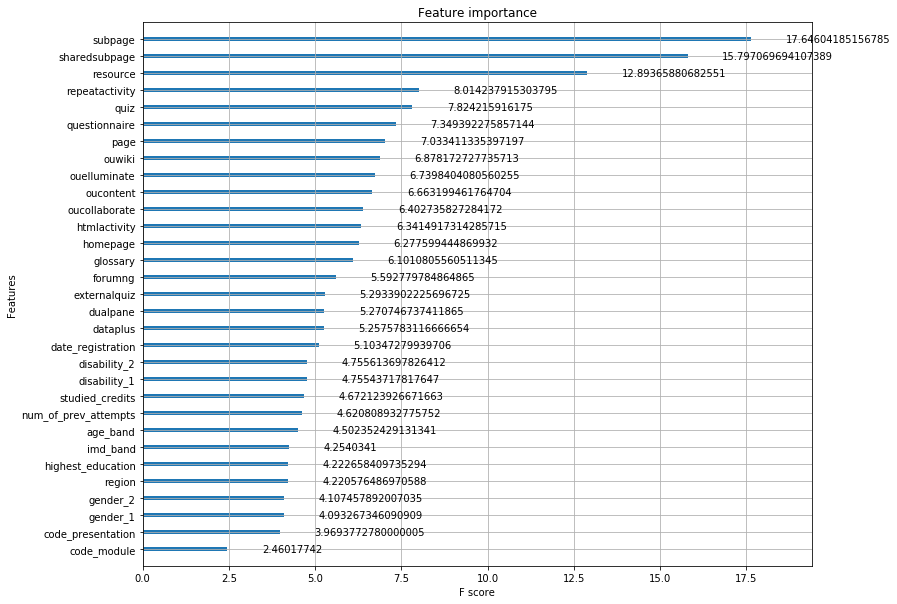

In [93]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, importance_type='gain').set_yticklabels(data_train)

plot_features(xgb, (12,10));

# Grid Search

In [112]:
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [4, 5, 6, 7],
    'min_child_weight': [4, 5, 6],
    'subsample': [1, 0.85, 0.75],
    'n_estimators': [80, 90, 100, 120],
    'colsample_bytree': [1, 0.85, 0.75],
    'class_weight': ['balanced']
}

In [113]:
import xgboost as xgb

clf = xgb.XGBClassifier()

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)

grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=cv, n_jobs=1)
grid_clf.fit(data_train, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(data_train)
val_preds = grid_clf.predict(data_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))
print('-----------------------------------------')
print(f'Null score: {ns}')
print(classification_report(y_test, val_preds))

Grid Search found the following optimal parameters: 
class_weight: 'balanced'
colsample_bytree: 0.85
learning_rate: 0.1
max_depth: 5
min_child_weight: 5
n_estimators: 120
subsample: 0.85

Training Accuracy: 74.91%
Validation accuracy: 71.77%
-----------------------------------------
Null score: 0.40641381436941104
              precision    recall  f1-score   support

           0       0.70      0.54      0.61      2636
           1       0.73      0.84      0.78      3850

    accuracy                           0.72      6486
   macro avg       0.71      0.69      0.69      6486
weighted avg       0.72      0.72      0.71      6486



In [118]:
st.title('Open University - machine learning')
st.dataframe(df, 10000, 700)